In [1]:
import sys
sys.path.append("../src")
import numpy as np
import pandas as pd
from opt_summary import OptSummary
from sd_summary import SDSummary
from no_del_summary import NoDeletionSummary
import time
import stopit
import warnings
from utils import *
plt.rc('axes', axisbelow=True)
np.random.seed(0)
@stopit.threading_timeoutable(default=(np.nan, np.nan))
def exec_summary(s, values, f, k, beta, jit=False, del_percentage=0.02):
    start_time = time.time()
    if s == 'NO DEL':
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'DS':
        values, f = outlier_removal(values, f, del_percentage)
        test = NoDeletionSummary(values, f, beta)
        err = test.summarize()
    elif s == 'SD CON':
        test = SDSummary(values, f, beta, k, method='con')
        err = test.summarize(k)
    elif s == 'SD ARB':
        test = SDSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
    elif s == 'CON': 
        test = OptSummary(values, f, beta, k, method='con')
        if jit == True:
            test.jit == True
        err = test.summarize(k)
    elif s == 'ARB':
        test = OptSummary(values, f, beta, k, method='arb')
        err = test.summarize(k)
        
    elapsed = (time.time() - start_time)
    return err, elapsed

### In the cell below you can specify the parameters for the experiments on synthetic data.
- timeout: In seconds. Choose how long a summary is allowed to run before stoping its execution.(Use a smaller timeout for the experiments to run faster. However SD ARB and ARB algorithms will probably yield no result if it is too low as they are the slowest ones)
- distribution: Uncomment one of the two available distributions, either `normal` or `permzipf`.
- data_size: integer, Specify how many datapoints will be generated.


In [2]:
timeout = 30
distribution = 'normal'
# distribution = 'permzipf'
if distribution == 'normal':
    generator = generate_norm_data
    a = 0.25
elif distribution == 'permzipf':
    generator = generate_permzipf_data
    a = 0.85

data_size = 1000
    


### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### Number of buckets = 10, Number of deletions = a percentage ρ = 2% of the size of the dataset.

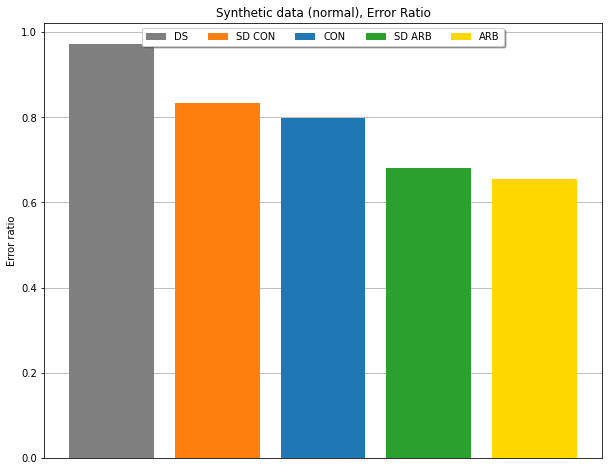

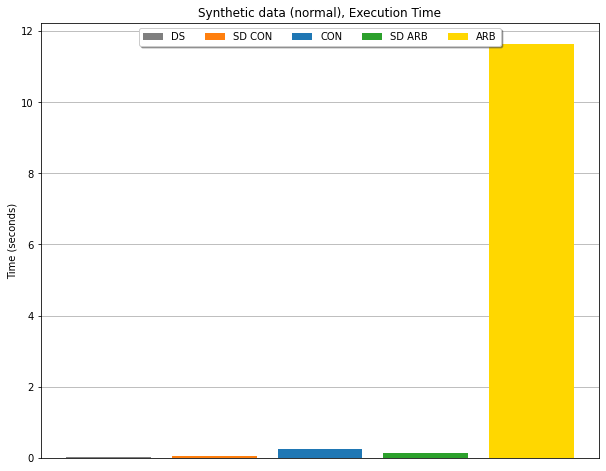

In [3]:
iterations = 3
no_del_errors = []
ds_errors = []
sd_con_errors = []
sd_arb_errors = []
opt_con_errors = []
opt_arb_errors = []
no_del_times = []
ds_times = []
sd_con_times = []
sd_arb_times = []
opt_con_times = []
opt_arb_times = []
beta = 10
del_percentage = 0.02

for i in range(iterations):
    values, f =  generator(1, 100, a, data_size)
    
    k = int(np.sum(f) * del_percentage)
    
    err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
    no_del_errors.append(err)
    no_del_times.append(elapsed)
    
    err, elapsed = exec_summary('DS', values, f, k, beta, timeout=timeout)
    ds_errors.append(err)
    ds_times.append(elapsed)

    err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
    sd_arb_errors.append(err)
    sd_arb_times.append(elapsed)

    err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
    sd_con_errors.append(err)
    sd_con_times.append(elapsed)
    
    err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
    opt_arb_errors.append(err)
    opt_arb_times.append(elapsed)

    err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
    opt_con_errors.append(err)
    opt_con_times.append(elapsed)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    no_del = np.nanmean(no_del_errors)
    ds = np.nanmean(ds_errors)
    sd_arb = np.nanmean(sd_arb_errors)
    sd_con = np.nanmean(sd_con_errors)
    arb = np.nanmean(opt_arb_errors)
    con = np.nanmean(opt_con_errors)
ep = 1e-9
res_err = np.array([ds, sd_con, con, sd_arb, arb]) / (no_del + ep)

color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['DS', 'SD CON', 'CON', 'SD ARB', 'ARB']
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}), Error Ratio')
plt.ylabel('Error ratio')
plt.grid(axis='y', zorder=0)
for i, re in enumerate(res_err):
    plt.bar(i, np.nan_to_num(re), color = color[i], label = labels[i])
plt.xticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, shadow=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    no_del = np.nanmean(no_del_times)
    ds = np.nanmean(ds_times)
    sd_arb = np.nanmean(sd_arb_times)
    sd_con = np.nanmean(sd_con_times)
    arb = np.nanmean(opt_arb_times)
    con = np.nanmean(opt_con_times)
    res_err = np.array([ds, sd_con, con, sd_arb, arb])

color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['DS', 'SD CON', 'CON', 'SD ARB', 'ARB']
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}), Execution Time')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', zorder=0)
for i, re in enumerate(res_err):
    plt.bar(i, np.nan_to_num(re), color = color[i], label = labels[i])
plt.xticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, shadow=True)
plt.show()



### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### We keep the number of buckets constant (10) while varying the number of deletion from 1% to 5% of the size of the dataset.

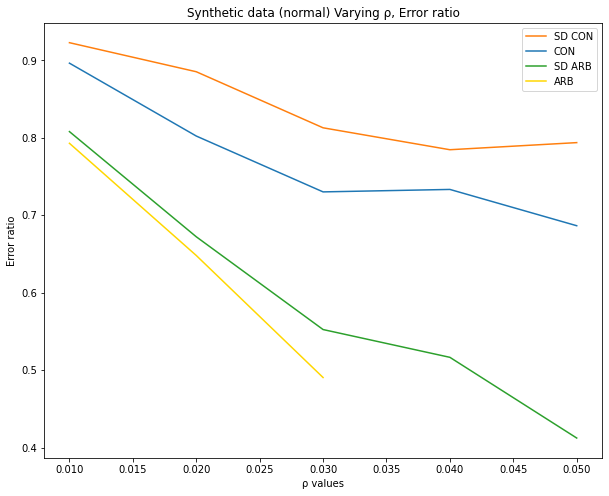

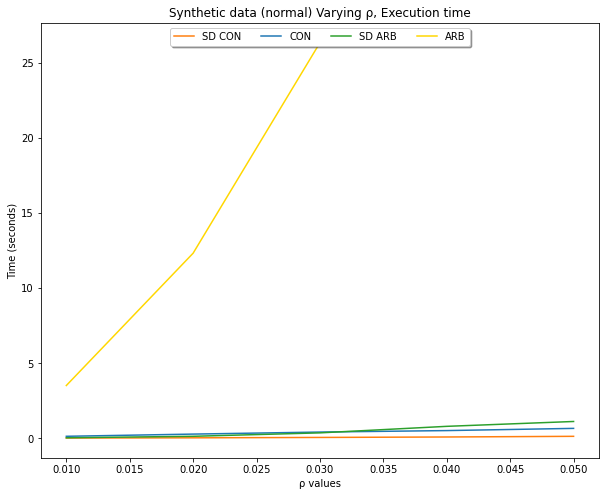

In [4]:
iterations = 3
beta = 10
del_percentages = list(np.linspace(0.01, 0.05, 5))

agg_sd_con_errors = []
agg_sd_arb_errors = []
agg_opt_con_errors = []
agg_opt_arb_errors = []

agg_sd_con_times = []
agg_sd_arb_times = []
agg_opt_con_times = []
agg_opt_arb_times = []

for del_percentage in del_percentages:
    no_del_errors = []
    ds_errors = []
    sd_con_errors = []
    sd_arb_errors = []
    opt_con_errors = []
    opt_arb_errors = []
    no_del_times = []
    ds_times = []
    sd_con_times = []
    sd_arb_times = []
    opt_con_times = []
    opt_arb_times = []
    for i in range(iterations):
        values, f =  generator(1, 100, a, data_size)

        k = int(np.sum(f) * del_percentage)

        err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
        no_del_errors.append(err)
        no_del_times.append(elapsed)

        err, elapsed = exec_summary('DS', values, f, k, beta, timeout=timeout)
        ds_errors.append(err)
        ds_times.append(elapsed)

        err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
        sd_arb_errors.append(err)
        sd_arb_times.append(elapsed)

        err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
        sd_con_errors.append(err)
        sd_con_times.append(elapsed)

        err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
        opt_arb_errors.append(err)
        opt_arb_times.append(elapsed)

        err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
        opt_con_errors.append(err)
        opt_con_times.append(elapsed)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        no_del = np.nanmean(no_del_errors)
        ds = np.nanmean(ds_errors)
        sd_arb = np.nanmean(sd_arb_errors)
        sd_con = np.nanmean(sd_con_errors)
        arb = np.nanmean(opt_arb_errors)
        con = np.nanmean(opt_con_errors)

        ep = 1e-9
        c = no_del + ep
        agg_opt_arb_errors.append(arb/c)
        agg_opt_con_errors.append(con/c)
        agg_sd_arb_errors.append(sd_arb/c)
        agg_sd_con_errors.append(sd_con/c)

        agg_opt_arb_times.append(np.nanmean(opt_arb_times))
        agg_opt_con_times.append(np.nanmean(opt_con_times))
        agg_sd_arb_times.append(np.nanmean(sd_arb_times))
        agg_sd_con_times.append(np.nanmean(sd_con_times))
    
    
color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_errors = [agg_sd_con_errors, agg_opt_con_errors, agg_sd_arb_errors, agg_opt_arb_errors]
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}) Varying ρ, Error ratio')
plt.ylabel('Error ratio')
plt.xlabel('ρ values')
for i, t in enumerate(res_errors):
    plt.plot(del_percentages, t, color=color[i], label=labels[i])
plt.legend()
plt.show()

color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_times = [agg_sd_con_times, agg_opt_con_times, agg_sd_arb_times, agg_opt_arb_times]
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}) Varying ρ, Execution time')
plt.ylabel('Time (seconds)')
plt.xlabel('ρ values')
for i, t in enumerate(res_times):
    plt.plot(del_percentages, t, color=color[i], label=labels[i])
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, shadow=True)
plt.show()


### Comparing the error ratio and the execution time of the algorithms on a uniform sample of the dataset.
### We keep the number of deletions constant (2% of the size of the data) while varying the number of buckets from 1 to 30.

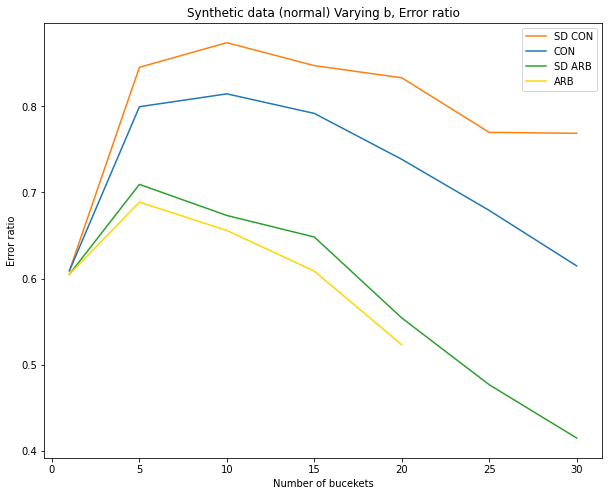

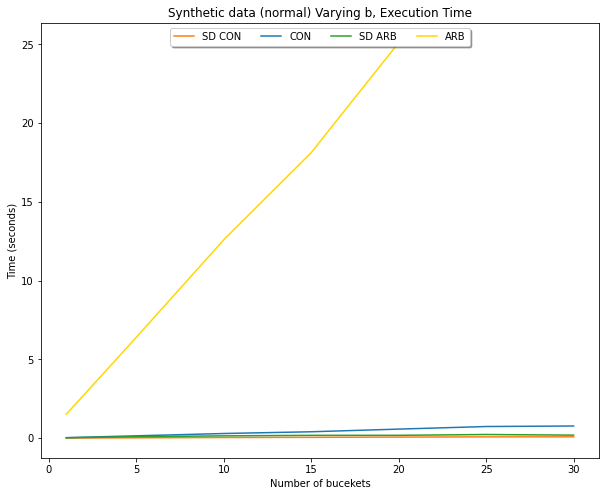

In [5]:

iterations = 3
del_percentage = 0.02
betas = [1, 5, 10, 15, 20, 25, 30]

agg_sd_con_errors = []
agg_sd_arb_errors = []
agg_opt_con_errors = []
agg_opt_arb_errors = []

agg_sd_con_times = []
agg_sd_arb_times = []
agg_opt_con_times = []
agg_opt_arb_times = []

for beta in betas:
    no_del_errors = []
    ds_errors = []
    sd_con_errors = []
    sd_arb_errors = []
    opt_con_errors = []
    opt_arb_errors = []
    no_del_times = []
    ds_times = []
    sd_con_times = []
    sd_arb_times = []
    opt_con_times = []
    opt_arb_times = []
    for i in range(iterations):
        values, f =  generator(1, 100, a, data_size)

        k = int(np.sum(f) * del_percentage)

        err, elapsed = exec_summary('NO DEL', values, f, k, beta, timeout=timeout)
        no_del_errors.append(err)
        no_del_times.append(elapsed)

        err, elapsed = exec_summary('DS', values, f, k, beta, timeout=timeout)
        ds_errors.append(err)
        ds_times.append(elapsed)

        err, elapsed = exec_summary('SD ARB', values, f, k, beta, timeout=timeout)
        sd_arb_errors.append(err)
        sd_arb_times.append(elapsed)

        err, elapsed = exec_summary('SD CON', values, f, k, beta, timeout=timeout)
        sd_con_errors.append(err)
        sd_con_times.append(elapsed)

        err, elapsed = exec_summary('ARB', values, f, k, beta, timeout=timeout)
        opt_arb_errors.append(err)
        opt_arb_times.append(elapsed)

        err, elapsed = exec_summary('CON', values, f, k, beta, timeout=timeout)
        opt_con_errors.append(err)
        opt_con_times.append(elapsed)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        no_del = np.nanmean(no_del_errors)
        ds = np.nanmean(ds_errors)
        sd_arb = np.nanmean(sd_arb_errors)
        sd_con = np.nanmean(sd_con_errors)
        arb = np.nanmean(opt_arb_errors)
        con = np.nanmean(opt_con_errors)

        ep = 1e-9
        c = no_del + ep
        agg_opt_arb_errors.append(arb/c)
        agg_opt_con_errors.append(con/c)
        agg_sd_arb_errors.append(sd_arb/c)
        agg_sd_con_errors.append(sd_con/c)

        agg_opt_arb_times.append(np.nanmean(opt_arb_times))
        agg_opt_con_times.append(np.nanmean(opt_con_times))
        agg_sd_arb_times.append(np.nanmean(sd_arb_times))
        agg_sd_con_times.append(np.nanmean(sd_con_times))
    
    
color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_errors = [agg_sd_con_errors, agg_opt_con_errors, agg_sd_arb_errors, agg_opt_arb_errors]
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}) Varying b, Error ratio')
plt.ylabel('Error ratio')
plt.xlabel('Number of bucekets')
for i, t in enumerate(res_errors):
    plt.plot(betas, t, color=color[i], label=labels[i])
plt.legend()
plt.show()

color = ['tab:orange', 'tab:blue', 'tab:green', 'gold']
labels = ['SD CON', 'CON', 'SD ARB', 'ARB']
res_times = [agg_sd_con_times, agg_opt_con_times, agg_sd_arb_times, agg_opt_arb_times]
plt.figure(figsize=(10,8))
plt.title(f'Synthetic data ({distribution}) Varying b, Execution Time')
plt.ylabel('Time (seconds)')
plt.xlabel('Number of bucekets')
for i, t in enumerate(res_times):
    plt.plot(betas, t, color=color[i], label=labels[i])
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fancybox=True, shadow=True)
plt.show()
